In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob, sys

[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import *
from plotting_utils import *
from lineplots import plotsd
from recalibration_utils import *
from session_utils import *
from metrics import estimateSNR
from simulation import * 
import simulation_utils 


from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score



In [ ]:
min_nblocks    = 2
max_ndays      = 1e99
participant    = 'T5'


FILE_DIR       = '/oak/stanford/groups/shenoy/ghwilson/nonstationarities/' + participant + '/'
fig_path       = '/home/users/ghwilson/projects/nonstationarities/figures/'
filelist       = glob.glob(FILE_DIR + 'historical/*')
filelist.extend(glob.glob(FILE_DIR + 'new/*'))

block_constraints = getBlockConstraints(FILE_DIR)

files          = get_Sessions(filelist, min_nblocks,  block_constraints = block_constraints)
pairs          = get_SessionPairs(files, max_ndays = max_ndays)
n_pairs        = len(pairs)


# for a reproducible result
np.random.seed(1)

## Do some RT and target dwell period characterizations

For a linear decoder with outputs $ u_{t} \in \mathbb{R}^{2} $, and a correct unit-norm point-at-target vector $p_{t}$, we can model:

  $u_{t} = \alpha p_{t} + N(0, \sigma^{2}) $

and define $SNR = \alpha / \sigma $. To model this effectively we chop out:

- RT interval - when participant is not yet using the decoder  (we'll determine this below)
- near target - where outputs can vary quickly with respect to $p_{t}$  (we determine this in *behavior_clicks.ipynb*)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


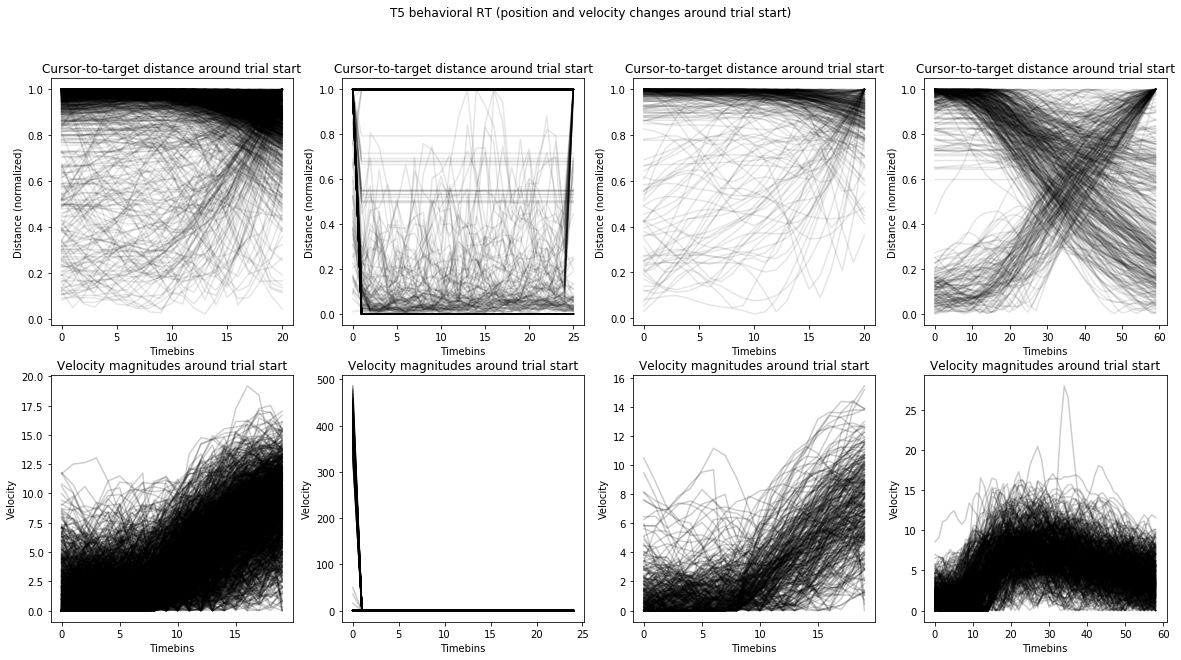

In [2]:
figSize(10, 20)

np.random.seed(42)
diffs           = list()
task            = None

for i, f in enumerate(np.random.choice(files, 4, replace = False)):
    dat     = DataStruct(f, alignScreens = True)

    _, cursorPos, targPos = getNeuralCursorTarget(dat, task = task, blocks = block_constraints[f])
    
    cursorPos = np.concatenate(cursorPos)
    targPos   = np.concatenate(targPos)
    cursorErr = [targ - cur for targ, cur in zip(targPos, cursorPos)]
    
    minlen     = np.min([cursorErr[i].shape[0] for i in range(len(cursorErr))])
    starts     = np.dstack([cursorErr[i][:minlen, :] for i in range(len(cursorErr))])
    dists      = np.linalg.norm(starts, axis = 1)

    plt.subplot(2, 4, i + 1)
    _ = plt.plot(dists / dists.max(axis = 0), color = 'k', alpha = 0.1)
    plt.ylabel('Distance (normalized)')
    plt.xlabel('Timebins')
    plt.title('Cursor-to-target distance around trial start')
    
    minlen     = np.min([cursorPos[i].shape[0] for i in range(len(cursorPos))])
    velocities = [np.diff(cursorPos[i][:minlen, :], axis = 0) for i in range(len(cursorPos))]
    magnitudes = [np.linalg.norm(velocities[i], axis = 1) for i in range(len(cursorPos))]
    
    plt.subplot(2, 4, i + 5)
    for trl in magnitudes:
        plt.plot(trl - trl.min(), color = 'k', alpha = 0.2)
        
    plt.ylabel('Velocity')
    plt.xlabel('Timebins')
    plt.title('Velocity magnitudes around trial start')

plt.suptitle('T5 behavioral RT (position and velocity changes around trial start)')
plt.show()

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


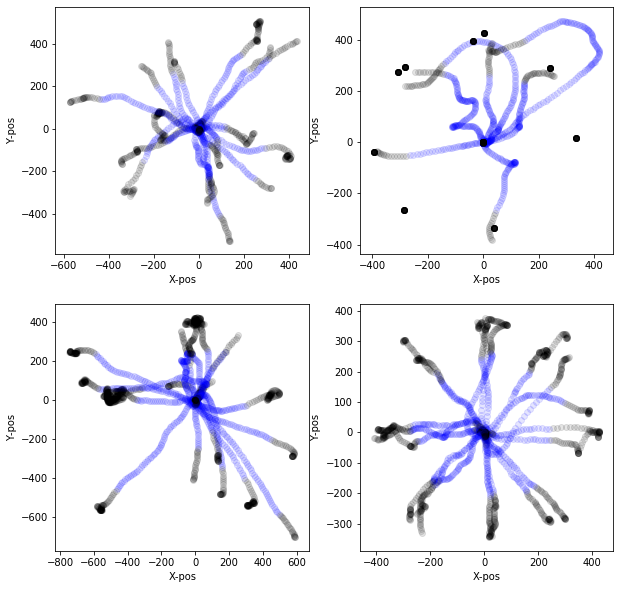

In [3]:
figSize(10, 10)

# general settings:
np.random.seed(42)
diffs           = list()
task            = None
train_size      = 0.5
sigma           = 0
n_plot          = 20   # number of reach trajectories to plot 

# SNR calculation settings:
thresh          = 150  # only calculate SNR using points far from target
cutStart        = 10   # exclude first 10 timesteps (200 ms to account for RT)


fields          = ['TX', 'cursorPos', 'targetPos']
for i, file in enumerate(np.random.choice(files, 4, replace = False)):
    session = DataStruct(file, alignScreens = True, causal_filter = sigma)
    
    blocks  = block_constraints[file]
    
    # get trial lens 
    session_dat = getTrainTest(session, fields = fields, train_size = train_size, 
                           task = task, blocks = blocks, returnFlattened = False) 
    start_times = np.cumsum([x.shape[0] for x in np.concatenate(session_dat['train_TX'])])


    # obtain features and cursorError targets:
    session_dat = getTrainTest(session, fields = fields, train_size = train_size, 
                               task = task, blocks = blocks, returnFlattened = True) 
    train_x, test_x = get_BlockwiseMeanSubtracted(session_dat['train_TX'], session_dat['test_TX'], concatenate = True)
    train_y         = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
    test_y          = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])
    train_cursorPos = np.concatenate(session_dat['train_cursorPos'])
    test_cursorPos  = np.concatenate(session_dat['test_cursorPos'])
    train_targetPos = np.concatenate(session_dat['train_targetPos'])
    
    n_trls       = len(start_times)
    
    _, usedIdx = estimateSNR(train_x, train_cursorPos, train_targetPos, start_times, minDist = thresh, cutStart = cutStart)
    
    plt.subplot(2, 2, i + 1)
    plt.xlabel('X-pos')
    plt.ylabel('Y-pos')
    for j in np.random.choice(n_trls, n_plot, replace = False):
        start      = start_times[j]
        stop       = start_times[j + 1] - 1
        targ       = train_cursorPos[stop, :] 
        trl_cursor = train_cursorPos[start:stop, :] - train_cursorPos[start, :]
        
        used       = np.in1d(np.arange(start, stop), usedIdx) 
        unused     = ~ used
        
        _ = plt.scatter(trl_cursor[used, 0], trl_cursor[used, 1], color = 'b', alpha = 0.1)
        _ = plt.scatter(trl_cursor[unused, 0], trl_cursor[unused, 1], color = 'k', alpha = 0.1)

plt.show()

plt.savefig(fig_path + 'SNR/T5_exampleTrialsColored', format = 'pdf')

In [4]:
# general settings:
np.random.seed(42)
diffs           = list()
task            = None
train_size      = 0.5
sigma           = 0

# SNR calculation settings:
thresh          = 300  # only calculate SNR using points far from target
cutStart        = 10   # exclude first 10 timesteps (200 ms to account for RT)


SNR_dict = dict()
SNR_dict['T5_SNR'] = np.zeros((len(files)))
SNR_dict['T5_r']   = np.zeros((len(files)))
SNR_dict['T5_R2']  = np.zeros((len(files)))

fields = ['TX', 'cursorPos', 'targetPos']
for i, file in enumerate(files):  
    session = DataStruct(file, alignScreens = True, causal_filter = sigma)
    blocks  = block_constraints[file]

    # get trial lens 
    session_dat  = getTrainTest(session, fields = fields, train_size = train_size, 
                           task = task, blocks = blocks, returnFlattened = False) 
    input_starts = np.cumsum([x.shape[0] for x in np.concatenate(session_dat['train_TX'])])

    # obtain features and cursorError targets:
    session_dat = getTrainTest(session, fields = fields, train_size = train_size, 
                               task = task, blocks = blocks, returnFlattened = True) 
    train_x, test_x = get_BlockwiseMeanSubtracted(session_dat['train_TX'], session_dat['test_TX'], concatenate = True)
    train_y         = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
    test_y          = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])
    train_cursorPos = np.concatenate(session_dat['train_cursorPos'])
    test_cursorPos  = np.concatenate(session_dat['test_cursorPos'])
    train_targetPos = np.concatenate(session_dat['train_targetPos'])
    
    SNR, usedIdx = estimateSNR(train_x, train_cursorPos, train_targetPos, input_starts, minDist = thresh, cutStart = cutStart)
    lm           = LinearRegression().fit(train_x, train_y)
    
    SNR_dict['T5_SNR'][i] = SNR
    SNR_dict['T5_r'][i]   = np.corrcoef(lm.predict(test_x).flatten(), test_y.flatten())[0, 1]
    SNR_dict['T5_R2'][i]  = lm.score(test_x, test_y)
    
    
    if (i + 1) % 20 == 0:
        print(i+1, '/', len(files), ' complete.')

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


20 / 74  complete.
40 / 74  complete.
60 / 74  complete.


/home/users/ghwilson/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


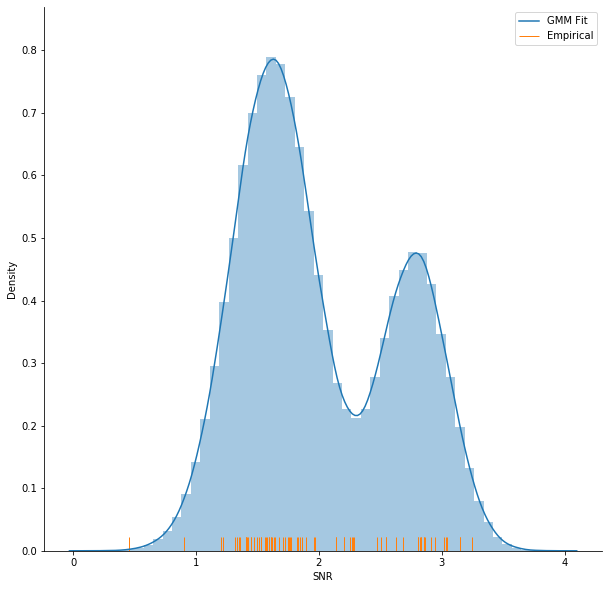

In [5]:
from scipy.stats import beta
from sklearn.mixture import GaussianMixture
import seaborn as sns 

figSize(5, 5)

gmm = GaussianMixture(n_components = 2).fit(SNR_dict['T5_SNR'][:, None])
x   = gmm.sample(400000)[0]
sns.distplot(x = x.flatten())
sns.rugplot(SNR_dict['T5_SNR'])
plt.legend(['GMM Fit', 'Empirical'])
plt.xlabel('SNR')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

### Simulator calibration

Code for fidgeting with simulator to get it near T5 dataset characteristics


In [2]:
from scipy.stats import beta 

def sampleSNR():

    # use GMM sampling to sample SNRs
    means = np.array([[2.78165778], [1.6244981 ]])
    covs  = np.array([[[0.07465756]], [[0.11382677]]])
    
    z = np.random.binomial(1, 0.6716436)
    y = np.random.normal(means[z], covs[z]**0.5) 
    
    # conversion adjustment (to encoding magnitude; see below)
    y *= 0.3365
    y -= 0.04438
    
    return y

In [7]:
from metrics import estimateSNR
import sklearn, copy

figSize(7, 7)

# Setup settings:
nUnits         = 192
SNR            = 0.5
nTrainingSteps = 10000
  

# simulator settings:
cfg = dict()
possibleGain       = np.linspace(0.1,2.5,10)
cfg['nDelaySteps'] = 10    # define the simulated user's visual feedback delay (200 ms)
cfg['nSimSteps']   = 10000
cfg['delT']        = 0.02  # define the time step (sec)
cfg['alpha']       = 0.94  # amount of exponential smoothing (0.9 to 0.96 are reasonable)

# SNR calc settings:
nReps           = 100
thresh          = 0.3   # only calculate SNR using points far from target
cutStart        = 7     # exclude first <cutStart> timesteps

# ---------------------------------

SNR_dict['simulator_SNR'] = np.zeros((nReps))
SNR_dict['simulator_R2']  = np.zeros((nReps))
SNR_dict['simulator_encoding_magnitude'] = np.zeros((nReps))

for n in range(nReps):
    
    encoding_mag           = sampleSNR()
    initialTuning          = simulation_utils.generateUnits(n_units = nUnits, SNR = encoding_mag)
    calNeural, calVelocity = simulation_utils.simulateUnitActivity(initialTuning, noise = 0.3, nSteps= nTrainingSteps)
    lr                     = LinearRegression(fit_intercept = True).fit(calNeural, calVelocity)
    D                      = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_]).T

    # Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
    D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(initialTuning[:, 1])
    D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(initialTuning[:, 2])
    
    rep_cfg = copy.deepcopy(cfg)
    rep_cfg['neuralTuning'] = initialTuning
    rep_cfg['D']            = D
    rep_cfg['beta']         = simulation_utils.gainSweep(rep_cfg, possibleGain)
    
    rep_result   = simulateBCIFitts(rep_cfg)
    SNR, usedIdx = estimateSNR(rep_result['neuralTraj'], rep_result['posTraj'], rep_result['targTraj'], 
                               rep_result['trialStart'], thresh, cutStart)
    
    train_x, test_x, train_y, test_y = sklearn.model_selection.train_test_split(rep_result['neuralTraj'], rep_result['targTraj'] - rep_result['posTraj'],
                                                                               train_size = 0.8)

    SNR_dict['simulator_SNR'][n] = SNR
    SNR_dict['simulator_R2'][n]  = LinearRegression().fit(train_x, train_y).score(test_x, test_y)
    SNR_dict['simulator_encoding_magnitude'][n] = encoding_mag

    if ( n + 1) % 10 == 0:
        print(n + 1, '/', nReps, ' complete.')

../utils/simulation/simulation.py:193: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  simAct  = getNeuralTuning(currControl, decode_params)
../utils/simulation/simulation.py:196: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  rawDecVec = getDecodedControl(simAct, decode_params)
/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


10 / 100  complete.
20 / 100  complete.
30 / 100  complete.
40 / 100  complete.
50 / 100  complete.
60 / 100  complete.
70 / 100  complete.
80 / 100  complete.
90 / 100  complete.
100 / 100  complete.


Correlation =  0.9877055554151749
Conversion:  [-0.00472433] [[0.31800148]]


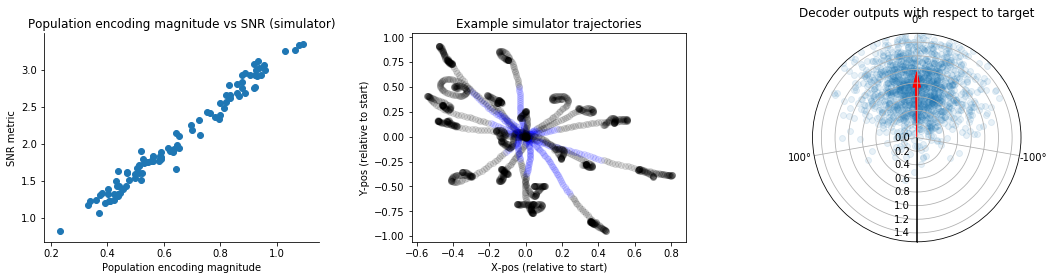

In [8]:
import seaborn as sns
from CosineTuning import getAngles

figSize(4, 15)

vals = list()
for i in range(10000):
    vals.append(sampleSNR())

plt.subplot(1, 3, 1)
plt.scatter(SNR_dict['simulator_encoding_magnitude'], SNR_dict['simulator_SNR'])
plt.xlabel('Population encoding magnitude')
plt.ylabel('SNR metric')
plt.title('Population encoding magnitude vs SNR (simulator)')
lm = LinearRegression().fit(SNR_dict['simulator_SNR'][:, None], SNR_dict['simulator_encoding_magnitude'][:, None])
r  = np.corrcoef(SNR_dict['simulator_encoding_magnitude'], SNR_dict['simulator_SNR'])
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

print('Correlation = ', r[0, 1])
print('Conversion: ', lm.intercept_, lm.coef_)



# example trials with delineated timepoints used in SNR calculation:
plt.subplot(1, 3, 2)
for i in range(30, 50):
    start = int(rep_result['trialStart'][i])
    stop  = int(rep_result['trialStart'][i+1] - 1)

    trlTraj          = rep_result['posTraj'][start:stop, :] 
    trlTraj_centered = trlTraj - rep_result['posTraj'][start, :]
    
    used   = np.in1d(np.arange(start, stop), usedIdx) 
    unused = ~ used

    _ = plt.scatter(trlTraj_centered[used, 0], trlTraj_centered[used, 1], color = 'b', alpha = 0.1)
    _ = plt.scatter(trlTraj_centered[unused, 0], trlTraj_centered[unused, 1], color = 'k', alpha = 0.1)

plt.xlabel('X-pos (relative to start)')
plt.ylabel('Y-pos (relative to start)')
plt.title('Example simulator trajectories')

# decoder and point-at-target vector angles, with SNR modeling:
plt.subplot(133, projection = 'polar')
cursorErr = rep_result['targTraj'] - rep_result['posTraj']
dists     = np.linalg.norm(cursorErr[usedIdx, :], axis = 1)
p_t       = cursorErr[usedIdx, :] / dists[:, np.newaxis]  # unit vector pointing at target
u_t       = lr.predict(rep_result['neuralTraj'][usedIdx, :])  
mult      = np.linalg.lstsq(p_t, u_t, rcond = None)[0][0][0]
res       = u_t - (p_t * mult)
SNR       = mult / np.std(res)
angles    = getAngles(u_t, p_t) * np.sign(np.cross(p_t, u_t)) # get absolute angle deviation not inner angle
magn      = np.linalg.norm(u_t, axis = 1)

plt.scatter(angles, magn, alpha = 0.1)
plt.arrow(0, 0, 0, mult, color = 'r', width=0.05, alpha  = 1)
ax = plt.gca()
ax.set_theta_zero_location("N")
ax.set_thetamin(-180)
ax.set_thetamax(179.9)
plt.title('Decoder outputs with respect to target')

plt.tight_layout()
plt.show()

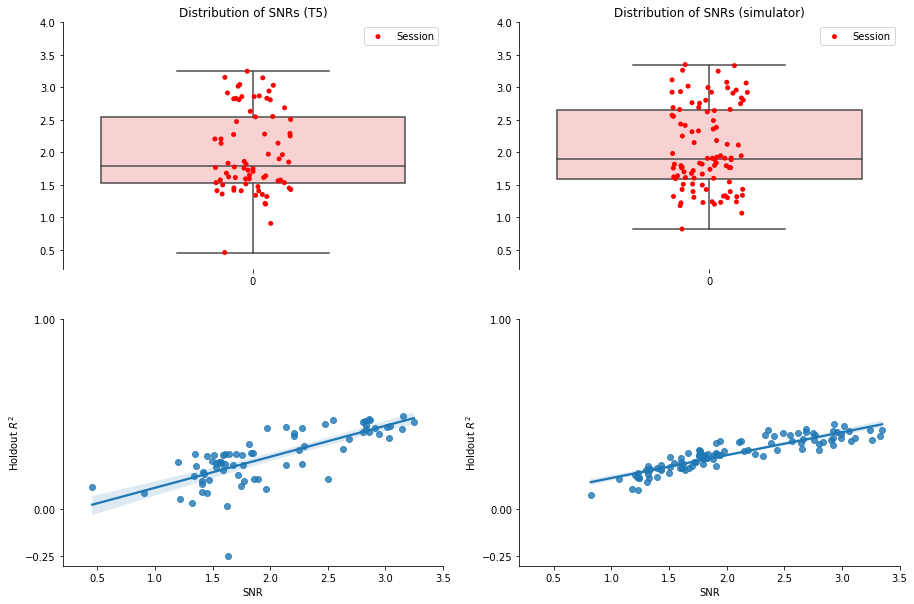

In [9]:
import seaborn as sns
from CosineTuning import getAngles
from plotting_utils import modifyBoxPlotAlpha

figSize(10, 15)

labels = ['T5', 'simulator']
for i, label in enumerate(labels):
    SNR_data = SNR_dict['{}_SNR'.format(label)]
    R2_data  = SNR_dict['{}_R2'.format(label)]

    plt.subplot(2, 2, i + 1)
    
    plt.title('Distribution of SNRs ({})'.format(label))
    sns.boxplot(data = SNR_data, orient = 'v', color = 'r')
    ax = plt.gca()
    modifyBoxPlotAlpha(ax, 0.2)
    sns.stripplot(data = SNR_data, orient = 'v', color = 'r', label = 'Session', jitter = 0.1)
    plt.ylim((0.2, 4))
    plt.legend()
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    plt.subplot(2, 2, i + 3)
    #plt.scatter(SNR_data, R2_data)
    plt.ylim([-0.3, 1])
    plt.yticks([-0.25, 0, 1])
    plt.xlim([0.2, 3.5])
    sns.regplot(x = SNR_data[R2_data > -1e10], y = R2_data[R2_data > -1e10], ci = 95)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlabel('SNR')
    plt.ylabel('Holdout $R^2$')

plt.savefig(fig_path + 'SNR/simulator_vs_T5_SNRs', format = 'pdf')
plt.show()

both R$^{2}$ and SNR seem to be in T5 range (median T5 SNR = 1.7,  R$^{2}$ usually in 0.4 area). Now let's see how our subspace shift dynamics match up to that of T5 as determined by cos(theta).


### Fitting drift


In [3]:
def simulateDrift(nUnits, nDays, tuning_shift):
    
    
    cos_angles = np.zeros((n_days, 2))
    
    init_SNR       = sampleSNR() 
    initialTuning  = generateUnits(n_units = nUnits, SNR = init_SNR)
    tuning         = np.copy(initialTuning)
    
    calNeural, calVelocity = simulateUnitActivity(initialTuning, noise = 0.3, nSteps= nTrainingSteps)
    initEnc                = fitEncodingMatrix(calVelocity, calNeural, fitMean = False)
    initEnc               /= np.linalg.norm(initEnc, axis = 0)
    
    for j in range(n_days):
        tuning = simulateTuningShift(tuning, PD_shrinkage = tuning_shift[0], PD_noisevar = tuning_shift[1], 
                                     mean_shift = tuning_shift[2], renormalize = renormalize)

        calNeural, calVelocity = simulateUnitActivity(initialTuning, noise = 0.3, nSteps= nTrainingSteps)
        enc                    = fitEncodingMatrix(calVelocity, calNeural, fitMean = False)
        enc                   /= np.linalg.norm(enc, axis = 0)

        cos_angles[j, :] = np.diag(enc.dot(initEnc.T))
        
    return cos_angles 

    
    

In [4]:
from joblib import Parallel, delayed
from CosineTuning import unit_vector, fitEncodingMatrix, angle_between


# general settings:
nUnits         = 192
nTrainingSteps = 10000
n_repeats      = 100
tuning_shift   = [0.91, 1, 0.0]  # PD shrinkage, new tuning variance, and mean shift 
max_stretch    = 14              # simulate n_repeats random chains of nonstationarities out this many days

#-----------------------------------------
cos_angles     = np.zeros((n_repeats, max_stretch, 2, )) 


for i in range(n_repeats):
    init_SNR       = sampleSNR() 
    initialTuning  = simulation_utils.generateUnits(n_units = nUnits, SNR = init_SNR)
    tuning         = np.copy(initialTuning)
    
    calNeural, calVelocity = simulation_utils.simulateUnitActivity(initialTuning, noise = 0.3, nSteps= nTrainingSteps)
    initEnc                = fitEncodingMatrix(calVelocity, calNeural, fitMean = True)[0][1:, :]
    initEnc               /= np.linalg.norm(initEnc, axis = 1)[:, None]
    
    for j in range(max_stretch):
        tuning = simulation_utils.simulateTuningShift(tuning, PD_shrinkage = tuning_shift[0], PD_noisevar = tuning_shift[1], 
                                     mean_shift = tuning_shift[2], renormalize = sampleSNR() )     
        
        calNeural, calVelocity = simulation_utils.simulateUnitActivity(tuning, noise = 0.3, nSteps= nTrainingSteps)
        enc                    = fitEncodingMatrix(calVelocity, calNeural, fitMean = True)[0][1:, :]
        enc                   /= np.linalg.norm(enc, axis = 1)[:, None]

        cos_angles[i, j, :] = np.diag(enc.dot(initEnc.T))
        
    if (i + 1) % 10 == 0:
        print(i + 1, '/', n_repeats)
        
diffs      = np.concatenate([i * np.ones((n_repeats)) for i in range(1, max_stretch + 1)])

10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100


Base alpha =  0.9095405996971888
Base alpha =  0.9085636964463137


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


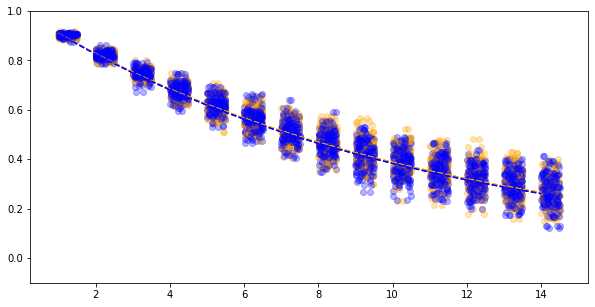

In [6]:
figSize(5, 10)

colors = ['orange', 'blue']
labels = ['X', 'Y']

for i in range(2):
    withinShrinkages  = cos_angles[:, :, i].reshape(-1)
    withinDiffs       = np.tile(np.arange(1, max_stretch + 1), 100).reshape(-1)
    x                 = np.arange(1, max(withinDiffs) + 1)
   # predx    = np.vstack([withinDiffs, np.ones(len(withinDiffs))]).T
   # mult, c  = np.linalg.lstsq(predx, np.log(withinShrinkages + 0.5)[:, np.newaxis], rcond = None)[0]
   # ypred    = np.exp((mult * x) + c) - 0.5

    predx = withinDiffs[withinShrinkages > 0, np.newaxis]
    mult  = np.linalg.lstsq(predx, np.log(withinShrinkages[withinShrinkages > 0])[:, np.newaxis], rcond = None)[0][0][0]
    ypred = np.exp(mult * x) 
    
    alpha    = np.exp(mult)
    print('Base alpha = ', alpha)

    plt.scatter(withinDiffs + 0.5 * np.random.rand(*withinDiffs.shape), withinShrinkages, alpha = 0.3, color = colors[i], label = labels[i])
    
    plt.plot(x, ypred, color = colors[i], linestyle = '--', label = 'alpha  = ' + str(np.round(alpha, 3)))
    
plt.ylim([-0.1, 1])
fig_path       = '/home/users/ghwilson/projects/nonstationarities/figures/'
plt.savefig(fig_path + 'SNR/simulator_encoder_drift_14days', format = 'pdf')
plt.show()

In [37]:
withinShrinkages.shape

(100, 14)